# **Task 1** 

**Given Task** : Clean your dataset (remove missing values, sanitize data, etc.). Remove any outliers (except 0s) using the Tukey’s rule from class using the default values as in class. Report what you found (number of outliers). Comment on your findings both for data cleaning (what issues you found, how you dealt with them) and outlier detection. 

In this task, we have checked for missing/null values.  <br>
Then we detected the outliers using Tukey's rule, removed them and reported the number of outliers and details of the findings. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
states_df = pd.read_csv("States Data/22.csv")

In [3]:
#Checking for null values in dataset
print(states_df.isnull().values.any())

False


There are **no missing values** in the dataset.

In [4]:
#Calculating the difference between each row as cumulative data is given in the states dataset. 
states_df_inter = states_df.set_index('Date').diff()
states_df_inter.fillna(0, inplace=True)

In [5]:
#Calculating the Q1, Q3 and IQR
Q1 = states_df_inter.quantile(0.25)
Q3 = states_df_inter.quantile(0.75)
IQR = Q3 - Q1
print("---- Lower range for Tukey's rule ----\n\n")
print("Column\t\tValue\n")
print(Q1 - 1.5 * IQR)
print("\n\n---- Upper range for Tukey's rule ----\n\n")
print("Column\t\tValue\n")
print(Q3 + 1.5 * IQR)

---- Lower range for Tukey's rule ----


Column		Value

TN confirmed    -2696.750
TX confirmed   -10068.125
TN deaths         -45.000
TX deaths        -213.000
dtype: float64


---- Upper range for Tukey's rule ----


Column		Value

TN confirmed     5275.250
TX confirmed    19458.875
TN deaths          83.000
TX deaths         401.000
dtype: float64


In [6]:
states_df_inter.shape

(438, 4)

In [7]:
states_df_inter.to_csv("States Data/22_inter.csv")

In [8]:
#Getting the rows which are outliers (detected by Tukey's rule with alpha = 1.5)
outliers = states_df_inter[((states_df_inter < (Q1 - 1.5 * IQR)) |(states_df_inter > (Q3 + 1.5 * IQR))).any(axis=1)]
outliers

,TN confirmed,TX confirmed,TN deaths,TX deaths
Date,,,,
2020-07-27,2547.0,4412.0,11.0,673.0
2020-07-31,5793.0,8360.0,27.0,295.0
2020-11-09,5860.0,4193.0,15.0,22.0
2020-11-11,3630.0,11071.0,89.0,141.0
2020-11-15,5817.0,6008.0,16.0,89.0
...,...,...,...,...
2021-02-03,1856.0,17372.0,133.0,418.0
2021-02-04,3154.0,15131.0,169.0,439.0
2021-02-05,2661.0,15357.0,203.0,401.0


In [9]:
outliers.to_csv("States Data/outliers.csv")
outliers_date = outliers.reset_index().iloc[:,0].tolist()

There were **62 outliers**. The outlier values can be found in outliers.csv

We can confirm the outliers from the box plots for the 4 columns 

<AxesSubplot:xlabel='TN confirmed'>

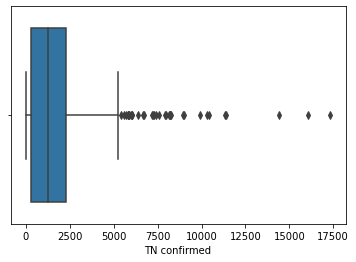

In [10]:
sns.boxplot(x=states_df_inter['TN confirmed'])

<AxesSubplot:xlabel='TX confirmed'>

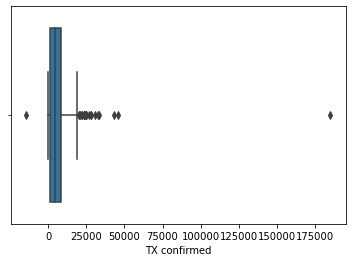

In [11]:
sns.boxplot(x=states_df_inter['TX confirmed'])

<AxesSubplot:xlabel='TN deaths'>

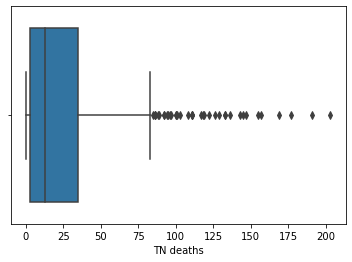

In [12]:
sns.boxplot(x=states_df_inter['TN deaths'])

<AxesSubplot:xlabel='TX deaths'>

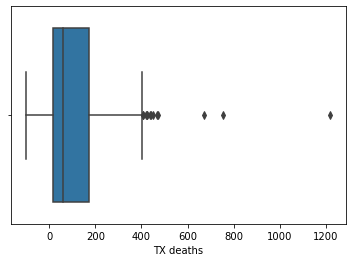

In [13]:
sns.boxplot(x=states_df_inter['TX deaths'])

In [14]:
#Removing the outliers from data
states_df_inter = states_df_inter.reset_index()
states_df_out = states_df_inter[~states_df_inter['Date'].isin(outliers_date)]
states_df_out.shape

(376, 5)

In [15]:
states_df_out.to_csv("States Data/22_cleaned.csv")

**The 62 outliers detected are dropped and the remaining daily data values are stored in 22_cleaned.csv**

# Required Inference 1 - AR and EWMA

**Given Task** : In this task, we want to predict COVID19 stats for each state. Use the COVID19 dataset to predict the COVID19 fatality and #cases for the fourth week in August 2020 using data from the first three weeks of August 2020. Do this separately for each of the two states. Use the following four prediction techniques: (i) AR(3), (ii) AR(5), (iii) EWMA with alpha = 0.5, and (iv) EWMA with alpha = 0.8. Report the accuracy (MAPE as a % and MSE) of your predictions using the actual fourth week data.

In [16]:
states_df_out.shape

(376, 5)

Filtering data to contain only the rows for the month of August

In [17]:
states_df_2a = states_df_out[((states_df_out['Date'] >= '2020-08-01') & (states_df_out['Date'] <= '2020-08-31'))]
states_df_2a.shape

(31, 5)

We are creating two dataframes - test (last week of August) and train (first 3 weeks of August)

In [18]:
train, test = states_df_2a[0:-7],states_df_2a[-7:]

## AR with p = 3 and 5 

In [19]:
#Helper function for MSE and MAPE
def getMSEandMAPE(actual, prediction):
    mse = 0
    mape = 0
    for x in range(len(actual)):
        mse += np.square(prediction[x] - actual[x])
        mape += abs(actual[x] - prediction[x])/actual[x]
    mse = mse/len(actual)
    mape = (mape/len(actual))*100
    return mse, mape 

In [20]:
#Helper function for plotting graph
def plotGraph(date, actual, prediction):
    plt.plot(date,actual,label="Actual")
    plt.plot(date,prediction,label="Prediction")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper left')
    plt.xticks(rotation=30)
    plt.show()

For Autoregression, we have written 3 methods : trainAR, getBetaValues and predictAR. <br>
We retrain the model as new information comes in before prediction (as discussed in class).

In [21]:
def trainAR(data,p,curLen):
    X = []
    Y = []
    for i in range(curLen):
        if i+p < curLen :
            X.append([1] + list(data[i:i+p]))
            Y.append(data[i+p])            
        else:
            break
    return X, Y

def getBetaValues(X,Y):
    beta=np.matmul(np.linalg.inv(np.matmul(np.transpose(X),X)),np.matmul(np.transpose(X),Y))
    return beta

def predictAR(train, test, p):
    data = np.hstack([train, test])
    trainLen = data.shape[0] - test.shape[0] 
    predictions = np.zeros(test.shape[0])
    for i in range(trainLen,data.shape[0]):
        dat = np.hstack([[1], data[i-p:i]])
        X,Y = trainAR(data, p, i)
        beta = getBetaValues(X,Y)
        predictions[i-trainLen] = np.matmul(dat,beta)

    return predictions

We are calculating AR(3) and AR(5) for all the 4 columns : TN confirmed, TX confirmed, TN deaths and TX deaths. <br>
We are displaying the results along with the MSE and MAPE% in a table, and also plotting the graph between actual and prediction results

 ---------------  TN confirmed  ----------------------  

         Date  Actual  Predicted AR(3)  Predicted AR(5)
0  2020-08-25   813.0      1682.735460      1717.652240
1  2020-08-26  1936.0      1419.627093      1475.290305
2  2020-08-27  1826.0      1718.582469      1587.893367
3  2020-08-28  1636.0      1634.727556      1960.396517
4  2020-08-29  1465.0      1579.627186      1784.786379
5  2020-08-30   835.0      1571.120433      1430.050688
6  2020-08-31  1818.0      1475.304503      1407.024957 

   p            MSE    MAPE(%)
0  3  243867.683117  36.349112
1  5  259689.443258  40.519518 


		p = 3


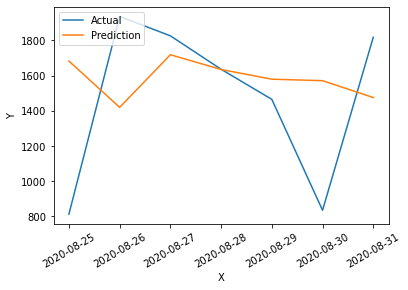




		p = 5


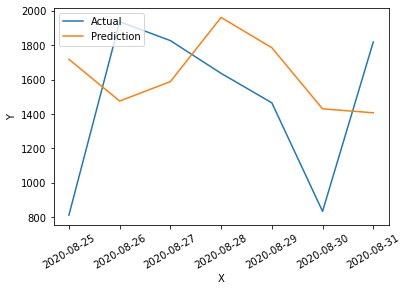




 ---------------  TX confirmed  ----------------------  

         Date  Actual  Predicted AR(3)  Predicted AR(5)
0  2020-08-25  6397.0      4514.706349      5236.600036
1  2020-08-26  5445.0      6367.400933      5873.624214
2  2020-08-27  5694.0      5893.878577      5255.526762
3  2020-08-28  4150.0      6077.947372      6443.795974
4  2020-08-29  4733.0      5312.722264      5779.291486
5  2020-08-30  3761.0      5401.093170      5391.265881
6  2020-08-31  2550.0      4753.796890      4802.147329 

   p           MSE    MAPE(%)
0  3  2.290499e+06  34.087384
1  5  2.258381e+06  34.679552 


		p = 3


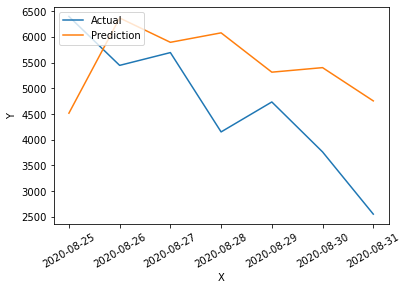




		p = 5


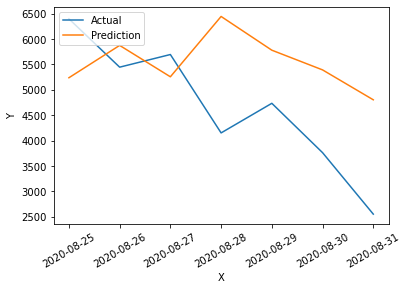




 ---------------  TN deaths  ----------------------  

         Date  Actual  Predicted AR(3)  Predicted AR(5)
0  2020-08-25    40.0        27.932749         8.964733
1  2020-08-26    20.0        29.877670        38.125933
2  2020-08-27    25.0        19.024509        21.368313
3  2020-08-28    28.0        23.921775        25.686135
4  2020-08-29    24.0        24.715985        22.474346
5  2020-08-30    22.0        23.070699        22.202311
6  2020-08-31     7.0        23.523434        23.651808 

   p         MSE    MAPE(%)
0  3   81.458318  51.703239
1  5  227.133090  62.309692 


		p = 3


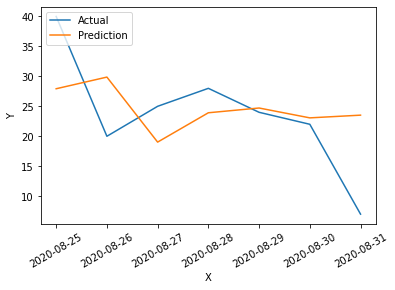




		p = 5


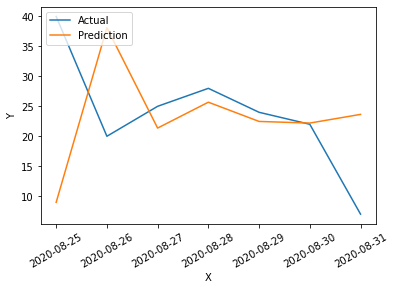




 ---------------  TX deaths  ----------------------  

         Date  Actual  Predicted AR(3)  Predicted AR(5)
0  2020-08-25   181.0       138.099671       228.313805
1  2020-08-26   229.0       292.103796       333.991673
2  2020-08-27   265.0       257.573662       306.541542
3  2020-08-28   196.0       233.817839       332.813780
4  2020-08-29   154.0       171.750801       228.116348
5  2020-08-30    90.0       169.063178       182.387426
6  2020-08-31    26.0       157.386058       159.839522 

   p          MSE     MAPE(%)
0  3  4448.034264   96.865821
1  5  9378.177823  117.573529 


		p = 3


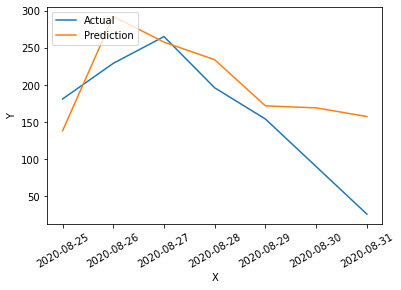




		p = 5


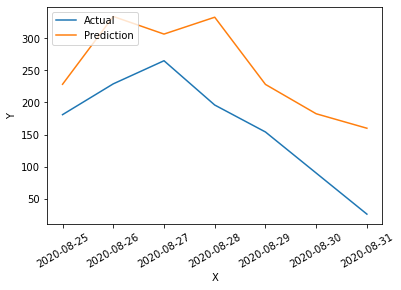

In [22]:
cols = ['TN confirmed', 'TX confirmed', 'TN deaths', 'TX deaths']
date = np.array(test['Date'])
for col in cols:
    
    actual = np.array(test[col])
    prediction_3 = predictAR(np.array(train[col]),np.array(test[col]), 3)
    prediction_5 = predictAR(np.array(train[col]),np.array(test[col]), 5)

    
    df_ar1 = pd.DataFrame()
    df_ar1['Date'] = date
    df_ar1['Actual'] = actual
    df_ar1['Predicted AR(3)'] = prediction_3
    df_ar1['Predicted AR(5)'] = prediction_5

    print('\033[1m --------------- ',col,' ---------------------- \033[0m \n')
    print(df_ar1, '\n')
    
    mse_3, mape_3 = getMSEandMAPE(actual,prediction_3)
    mse_5, mape_5 = getMSEandMAPE(actual,prediction_5)


    df_ar2 = pd.DataFrame()
    df_ar2['p'] = [3,5]
    df_ar2['MSE'] = mse_3, mse_5
    df_ar2['MAPE(%)'] = mape_3, mape_5
    print(df_ar2, '\n\n')
    
    
    print("\t\tp = 3")
    plotGraph(date, actual, prediction_3)
    print('\n\n')
    
    print("\t\tp = 5")
    plotGraph(date, actual, prediction_5)
    print('\n\n')

## EWMA with alpha = 0.5 and 0.8

For EWMA, I have one method to calculate the predictions based on the input alpha and data.

In [23]:
def EWMA(data, alpha):

    y_pred = []
    y_pred.append(data[0])
    for i in range(1,len(data)):
        y_pred.append(alpha * data[i-1] + (1 - alpha) * y_pred[i-1])

    y_actual = data
    #Computing MSE and MAPE for test set
    MSE, MAPE = getMSEandMAPE(y_pred[-7:], y_actual[-7:])
    return y_pred,MSE,MAPE

We are calculating EWMA with alpha = 0.5 and EWMA with alpha = 0.8 for all the 4 columns : TN confirmed, TX confirmed, TN deaths and TX deaths. <br>
We are displaying the results along with the MSE and MAPE% in a table, and also plotting the graph between actual and prediction results

 ---------------  TN confirmed  ----------------------  

         Date  Actual  Predicted_EWMA(0.5)  Predicted_EWMA(0.8)
0  2020-08-25   813.0          1149.772742           882.915525
1  2020-08-26  1936.0           981.386371           826.983105
2  2020-08-27  1826.0          1458.693185          1714.196621
3  2020-08-28  1636.0          1642.346593          1803.639324
4  2020-08-29  1465.0          1639.173296          1669.527865
5  2020-08-30   835.0          1552.086648          1505.905573
6  2020-08-31  1818.0          1193.543324           969.181115 


   Alpha            MSE    MAPE(%)
0    0.5  299164.767727  37.325142
1    0.8  355407.004003  43.174667 


		Alpha = 0.5


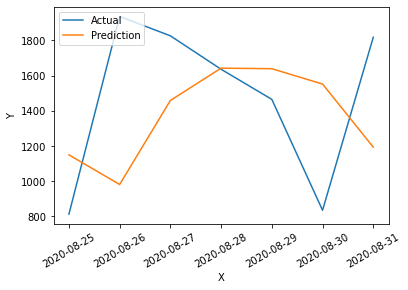




		Alpha = 0.8


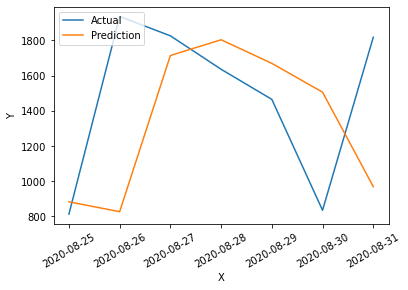




 ---------------  TX confirmed  ----------------------  

         Date  Actual  Predicted_EWMA(0.5)  Predicted_EWMA(0.8)
0  2020-08-25  6397.0          3918.991362          3185.316248
1  2020-08-26  5445.0          5157.995681          5754.663250
2  2020-08-27  5694.0          5301.497840          5506.932650
3  2020-08-28  4150.0          5497.748920          5656.586530
4  2020-08-29  4733.0          4823.874460          4451.317306
5  2020-08-30  3761.0          4778.437230          4676.663461
6  2020-08-31  2550.0          4269.718615          3944.132692 


   Alpha           MSE    MAPE(%)
0    0.5  1.742036e+06  23.452344
1    0.8  2.225285e+06  28.213501 


		Alpha = 0.5


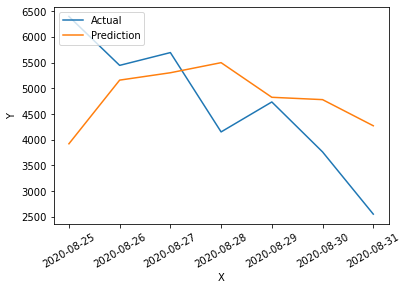




		Alpha = 0.8


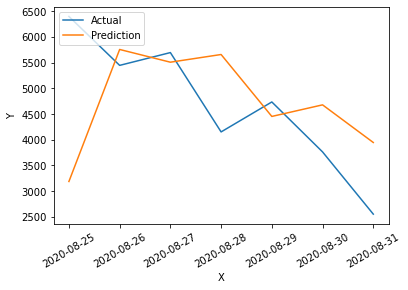




 ---------------  TN deaths  ----------------------  

         Date  Actual  Predicted_EWMA(0.5)  Predicted_EWMA(0.8)
0  2020-08-25    40.0            19.057459            18.333400
1  2020-08-26    20.0            29.528729            35.666680
2  2020-08-27    25.0            24.764365            23.133336
3  2020-08-28    28.0            24.882182            24.626667
4  2020-08-29    24.0            26.441091            27.325333
5  2020-08-30    22.0            25.220546            24.665067
6  2020-08-31     7.0            23.610273            22.533013 


   Alpha         MSE    MAPE(%)
0    0.5  118.770719  35.428052
1    0.8  141.312164  39.397461 


		Alpha = 0.5


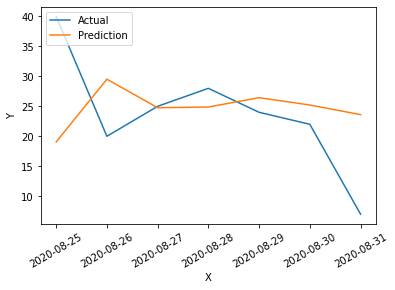




		Alpha = 0.8


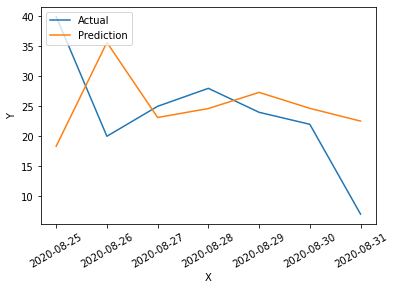




 ---------------  TX deaths  ----------------------  

         Date  Actual  Predicted_EWMA(0.5)  Predicted_EWMA(0.8)
0  2020-08-25   181.0            96.157597            45.529315
1  2020-08-26   229.0           138.578799           153.905863
2  2020-08-27   265.0           183.789399           213.981173
3  2020-08-28   196.0           224.394700           254.796235
4  2020-08-29   154.0           210.197350           207.759247
5  2020-08-30    90.0           182.098675           164.751849
6  2020-08-31    26.0           136.049337           104.950370 


   Alpha          MSE   MAPE(%)
0    0.5  6646.687472  52.64619
1    0.8  6394.630060  77.10447 


		Alpha = 0.5


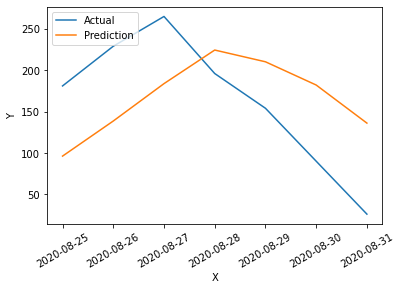




		Alpha = 0.8


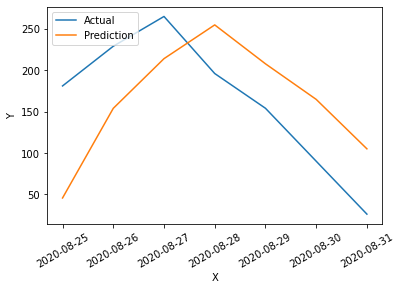

In [24]:
cols = ['TN confirmed', 'TX confirmed', 'TN deaths', 'TX deaths']
date = np.array(test['Date'])
for col in cols:

    y_predicted_point5, MSE_predicted_point5, MAPE_predicted_point5 = EWMA((states_df_2a[col]).tolist(),0.5)
    y_predicted_point8,MSE_predicted_point8, MAPE_predicted_point8  = EWMA((states_df_2a[col]).tolist(),0.8)

    df_ar1 = pd.DataFrame()
    actual = np.array(test[col])
    df_ar1['Date'] = date
    df_ar1['Actual'] = actual
    df_ar1['Predicted_EWMA(0.5)'] = y_predicted_point5[-7:]
    df_ar1['Predicted_EWMA(0.8)'] = y_predicted_point8[-7:]
    print('\033[1m --------------- ',col,' ---------------------- \033[0m \n')
    print(df_ar1, '\n\n')
    
    df_ar2 = pd.DataFrame()
    df_ar2['Alpha'] = [0.5,0.8]
    df_ar2['MSE'] = MSE_predicted_point5, MSE_predicted_point8
    df_ar2['MAPE(%)'] = MAPE_predicted_point5, MAPE_predicted_point8
    print(df_ar2, '\n\n')
    
    print("\t\tAlpha = 0.5")
    plotGraph(date, actual, y_predicted_point5[-7:])
    print('\n\n')
    
    print("\t\tAlpha = 0.8")
    plotGraph(date, actual, y_predicted_point8[-7:])
    print('\n\n')